# Investigate the impacts of different types of droughts on the UCRB

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import duckdb
import ast
import matplotlib.pyplot as plt

In [2]:
droughts_df = pd.read_csv('../rival_framings_demand/drought_counts_all_realizations.csv', index_col=0)
droughts_df.index = np.arange(1, len(droughts_df) + 1)
droughts_df

,Decadal counts,Multidecadal counts,Total counts,Drought years
1,0,0,0,"[[], []]"
2,21,0,21,"[[], [79, 80, 81, 82, 83, 84, 85, 86, 87, 88, ..."
3,0,50,50,"[[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, ..."
4,15,0,15,"[[], [96, 97, 98, 99, 100, 101, 102, 103, 89, ..."
5,22,0,22,"[[], [91, 92, 93, 94, 95, 96, 97, 98, 99, 36, ..."
...,...,...,...,...
996,0,0,0,"[[], []]"
997,0,0,0,"[[], []]"
998,13,0,13,"[[], [64, 65, 66, 67, 68, 69, 70, 71, 59, 60, ..."
999,0,0,0,"[[], []]"


In [3]:
# directory where the experiment data is stored
flow_data_dir = '../rival_framings_demand/xdd_parquet_flow'

Identify realizations similar or better than history (drought years=22)

In [4]:
realizations_history=tuple(map(str, np.where((droughts_df['Total counts'] >=10) & 
                                             (droughts_df['Total counts'] <= 22))[0]+1))

Function converting order number to sample and realization for file retrieval

In [5]:
no_to_realization = lambda x: (int(x/10)+1, (x)%10+1)

Identify all samples that produce these realizations

In [6]:
samples = tuple(np.unique([no_to_realization(int(x))[0] for x in realizations_history]))

Create glob path to specific realization results

In [7]:
# target glob path
glob_path = os.path.join(flow_data_dir, f'S*_*.parquet')

# number of files in file query
n_files = len(glob.glob(glob_path))

In [8]:
#limits rows to those that belong to list of realizations
sql = f"""
SELECT 
    *
FROM
    '{glob_path}'
WHERE
    (sample-1)*10+realization in {realizations_history}; 
"""

df = duckdb.query(sql).df()
df

,structure_id,year,month,demand,shortage,river_outflow,control_location,sample,realization
0,09010500,1908,OCT,0,0,1694,NaN,73,3
1,09010500,1908,NOV,0,0,1166,NaN,73,3
2,09010500,1908,DEC,0,0,920,NaN,73,3
3,09010500,1909,JAN,0,0,725,NaN,73,3
4,09010500,1909,FEB,0,0,597,NaN,73,3
...,...,...,...,...,...,...,...,...,...
45843835,09163500,2013,MAY,0,0,189992,NaN,7,8
45843836,09163500,2013,JUN,0,0,158893,NaN,7,8
45843837,09163500,2013,JUL,0,0,120461,NaN,7,8
45843838,09163500,2013,AUG,0,0,125278,NaN,7,8


In [9]:
df['realization_number']=(df['sample']-1)*10+df['realization']

In [10]:
df

,structure_id,year,month,demand,shortage,river_outflow,control_location,sample,realization,realization_number
0,09010500,1908,OCT,0,0,1694,NaN,73,3,723
1,09010500,1908,NOV,0,0,1166,NaN,73,3,723
2,09010500,1908,DEC,0,0,920,NaN,73,3,723
3,09010500,1909,JAN,0,0,725,NaN,73,3,723
4,09010500,1909,FEB,0,0,597,NaN,73,3,723
...,...,...,...,...,...,...,...,...,...,...
45843835,09163500,2013,MAY,0,0,189992,NaN,7,8,68
45843836,09163500,2013,JUN,0,0,158893,NaN,7,8,68
45843837,09163500,2013,JUL,0,0,120461,NaN,7,8,68
45843838,09163500,2013,AUG,0,0,125278,NaN,7,8,68


Calculate shortage to demand ratio for entire basin for every drought event

In [11]:
shortage_ratio = []
years_list = []
for i in realizations_history:
    years = ast.literal_eval(droughts_df.at[int(i),'Drought years'])[1]
    years = [x+1908 for x in years]
    total_demand = df.loc[(df['realization_number'] == int(i)) & (df['year'].isin(years)), 'demand'].sum()
    total_shortage = df.loc[(df['realization_number'] == int(i)) & (df['year'].isin(years)), 'shortage'].sum()
    shortage_ratio.append(total_shortage/total_demand)
    years_list.append(len(years))

Plot shortage ratio and duration for every drought event

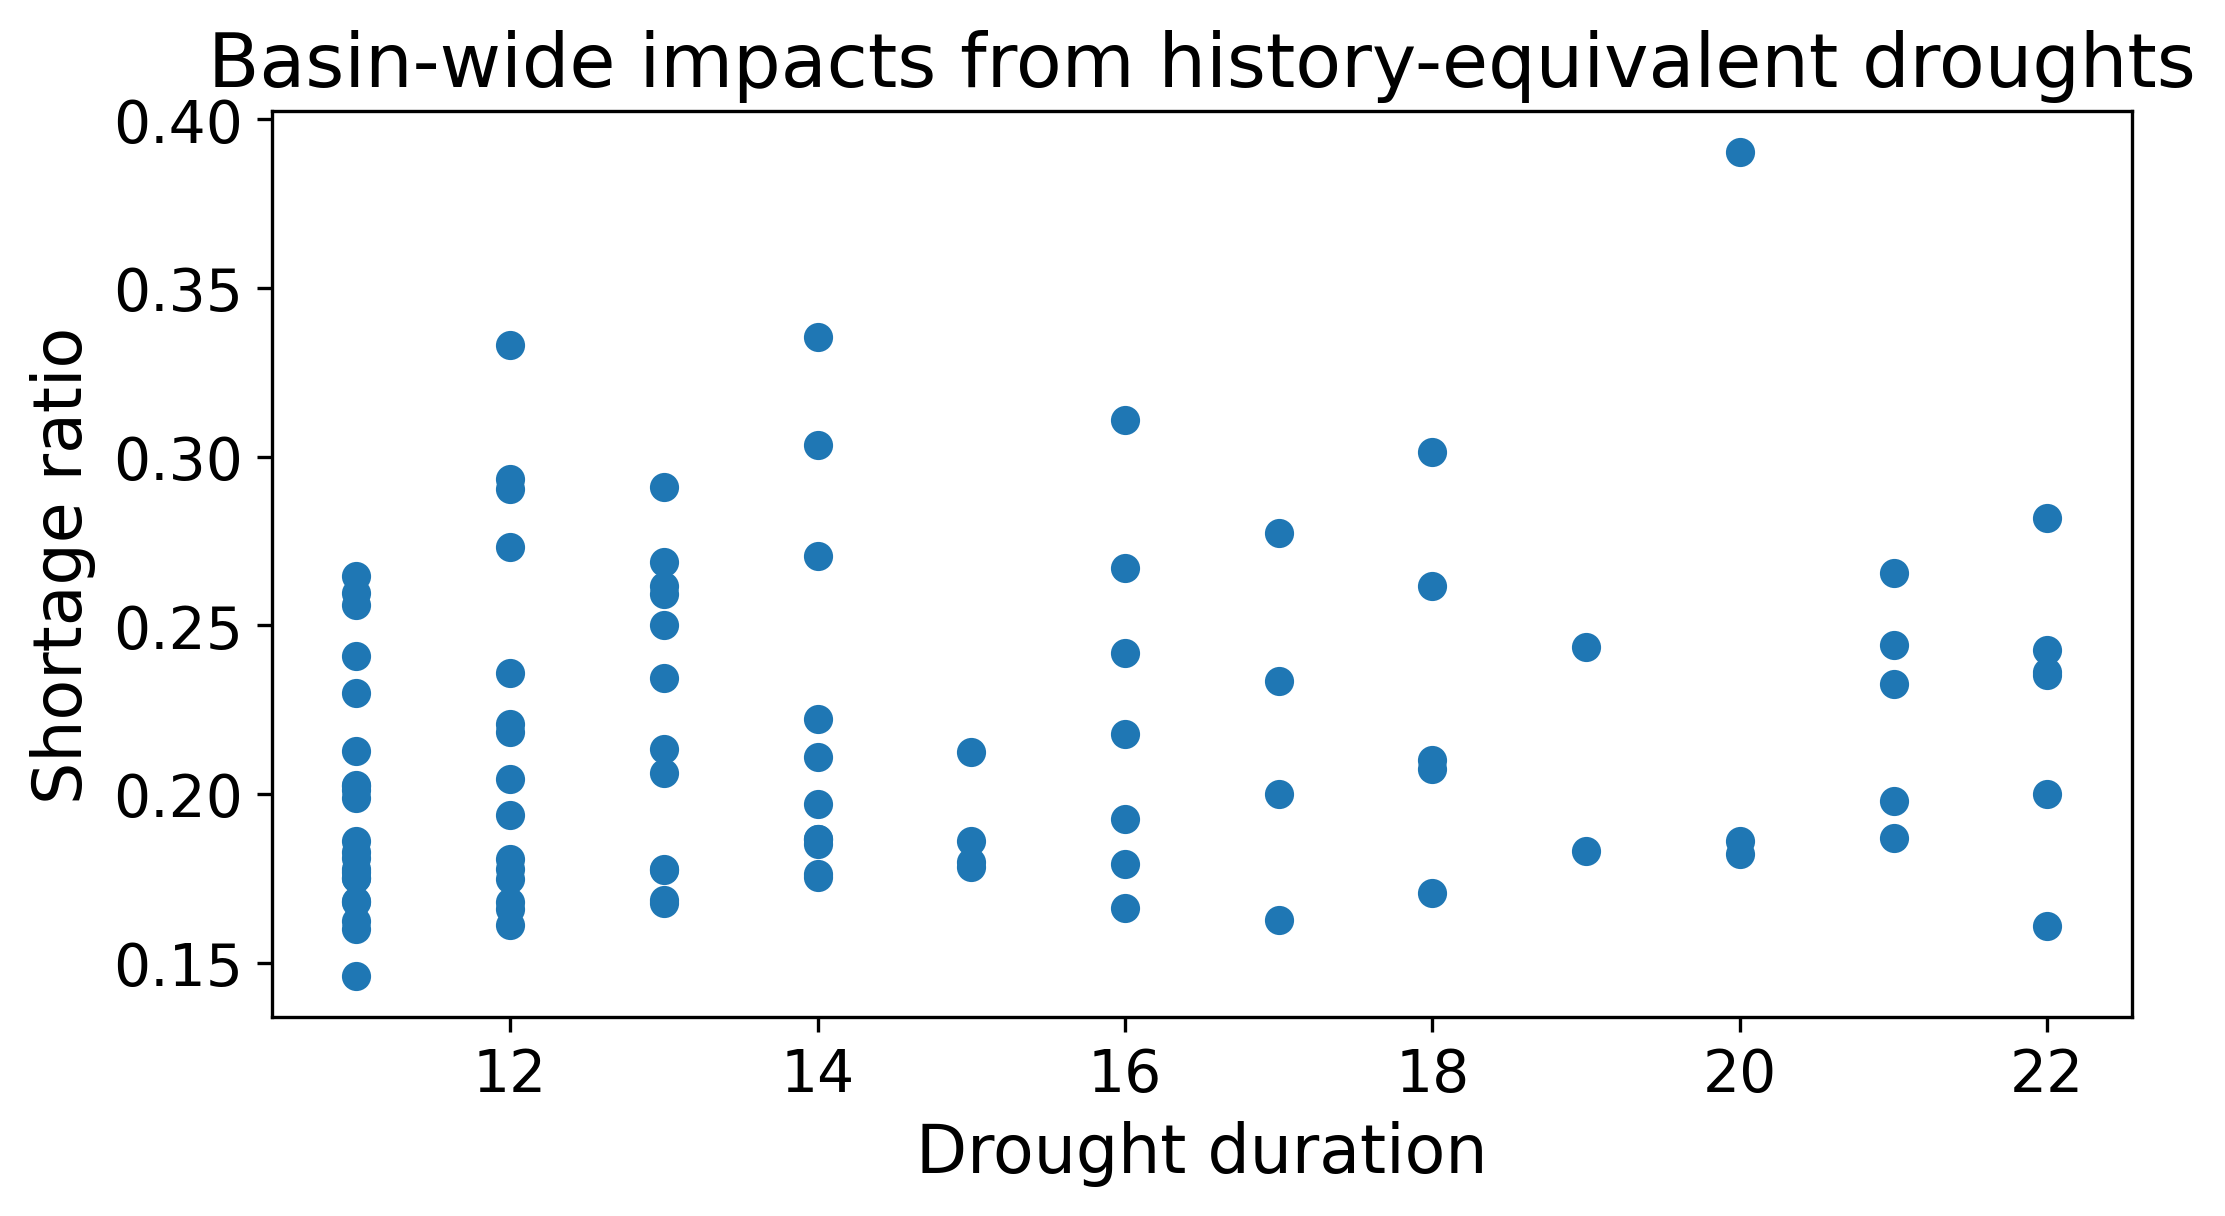

In [12]:
plt.figure(figsize=(8, 4), dpi=300)
plt.scatter(years_list, shortage_ratio)
plt.title("Basin-wide impacts from history-equivalent droughts", fontsize=18)
plt.xlabel("Drought duration (years)")
plt.ylabel("Shortage/demand ratio")
plt.tick_params(axis='both', labelsize=14)
plt.ylabel("Shortage ratio", fontsize=16)
plt.xlabel("Drought duration", fontsize=16)
plt.show()

## Investigate user and basin impacts of specific drought events

Create summary dataframe of drought metrics

In [13]:
d = {"realization_number": realizations_history, "shortage ratio": shortage_ratio, "duration": years_list}
pd.options.display.float_format = '{:,.2f}'.format
summary_df = pd.DataFrame(d)
summary_df

,realization_number,shortage ratio,duration
0,2,0.19,21
1,4,0.18,15
2,5,0.16,22
3,6,0.18,12
4,7,0.18,20
...,...,...,...
91,941,0.34,14
92,943,0.23,17
93,973,0.19,14
94,992,0.18,11


### Look at basin outflows
Delivery estimate for UCRB:

Colorado share 51.75% of 75MAF (over 10 years) = 38.8 MAF

Historic rolling sum deliveries (calculated in annual_outflow.txt)

In [27]:
deliveries_percentiles = [47188.4455, 49773.50211, 50883.05469, 51883.83987, 52885.69665,
                          53936.31123, 55008.80431, 59595.07407, 65741.68286, 74711.95786]
historic_mean = deliveries_percentiles[4]

Function to calculate rolling sum

In [15]:
def rolling_sum(timeseries):
    #script from https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/
    window_size = 10

    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []

    # Loop through the array to consider
    # every window of size 3
    while i < len(timeseries) - window_size + 1:
        # Store elements from i to i+window_size
        # in list to get the current window
        window = timeseries[i : i + window_size]

        # Calculate the average of current window
        window_sum = sum(window)

        # Store the average of current
        # window in moving average list
        moving_averages.append(window_sum)

        # Shift window to right by one position
        i += 1
    return moving_averages

Read regulated flows for all realizations for last gauge

In [16]:
# our target user
structure_id = '09163500'

sql = f"""
SELECT
    sample
    ,realization
    ,SUM(river_outflow) AS annual_river_outflow
    ,CASE month
            WHEN 'OCT' THEN year + 1
            WHEN 'NOV' THEN year + 1
            WHEN 'DEC' THEN year + 1
            WHEN 'JAN' THEN year
            WHEN 'FEB' THEN year
            WHEN 'MAR' THEN year
            WHEN 'APR' THEN year
            WHEN 'MAY' THEN year
            WHEN 'JUN' THEN year
            WHEN 'JUL' THEN year
            WHEN 'AUG' THEN year
            WHEN 'SEP' THEN year
            END AS water_year
FROM
    '{glob_path}'
GROUP BY
    structure_id
    ,water_year
    ,sample
    ,realization
HAVING
    structure_id = '{structure_id}'
ORDER BY
    sample
    ,realization
    ,water_year;
"""

# get query result as a data frame
df_flows = duckdb.query(sql).df()

In [17]:
df_flows['realization_number']=(df_flows['sample']-1)*10+df_flows['realization']
df_flows['annual_river_outflow']=df_flows['annual_river_outflow']*1233.4818/1000000
df_flows

,sample,realization,annual_river_outflow,water_year,realization_number
0,1,1,"2,491.77",1909,1
1,1,1,"5,518.83",1910,1
2,1,1,"4,341.56",1911,1
3,1,1,"5,888.51",1912,1
4,1,1,"5,761.24",1913,1
...,...,...,...,...,...
103945,100,10,"4,414.97",2009,1000
103946,100,10,"2,512.35",2010,1000
103947,100,10,"11,583.25",2011,1000
103948,100,10,"4,355.07",2012,1000


Pick specific drought events to compare

In [18]:
# Realization with smallest duration and highest shortage ratio
summary_df[summary_df['duration'] == 22].sort_values("shortage ratio", ascending=True)

,realization_number,shortage ratio,duration
2,5,0.16,22
26,178,0.20,22
42,431,0.24,22
83,896,0.24,22
10,31,0.24,22
88,905,0.28,22


Extract flows for realization and sum 

In [19]:
focus_real = 178
flows = df_flows['annual_river_outflow'][df_flows['realization_number']==focus_real]
roll_sum = rolling_sum(flows)

Highlight drought years

In [20]:
years = ast.literal_eval(droughts_df.at[focus_real,'Drought years'])[1]
years = [year+1909 for year in years]

In [21]:
years

[1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958]

Plot rolling sum of basin deliveries

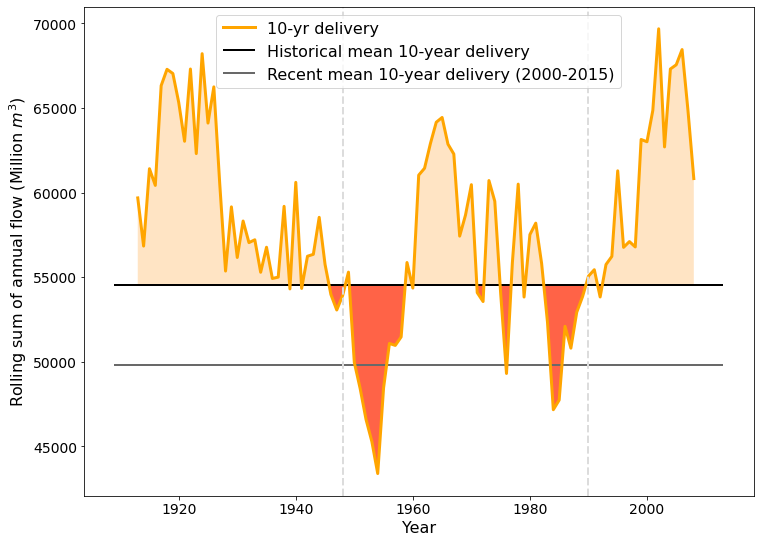

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12,9))
ax.plot(np.arange(1913, 2009), roll_sum, linewidth=3, color='orange', label='10-yr delivery')
ax.hlines(y=historic_mean, xmin=1909, xmax=2013, linewidth=2, color='black', 
          label='Historical mean 10-year delivery')
ax.hlines(y=recent_mean, xmin=1909, xmax=2013, linewidth=2, color='dimgrey', 
          label='Recent mean 10-year delivery (2000-2015)')
ax.fill_between(np.arange(1913, 2009), roll_sum, historic_mean, 
                where=np.asarray(roll_sum) >= historic_mean, facecolor='bisque', interpolate=True)
ax.fill_between(np.arange(1913, 2009), roll_sum, historic_mean, 
                where=np.asarray(roll_sum) <= historic_mean, facecolor='tomato', interpolate=True)
ax.axvline(x=np.min(years), linewidth=2, linestyle='--', color='gainsboro')
ax.axvline(x=np.max(years), linewidth=2, linestyle='--', color='gainsboro')
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel("Rolling sum of annual flow (Million $m^3$)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.legend(fontsize=16)
plt.show()

Drought impacts for users (pie charts on map) replicate this https://datavizproject.com/wp-content/uploads/2016/02/Sk%C3%A6rmbillede-2017-10-11-kl.-16.24.07.png

### Look at shortages before and during drought

In [23]:
sql = f"""
SELECT
    sample
    ,realization
    ,structure_id
    ,SUM(shortage) AS annual_shortage
    ,SUM(demand) AS annual_demand
    ,CASE month
            WHEN 'OCT' THEN year + 1
            WHEN 'NOV' THEN year + 1
            WHEN 'DEC' THEN year + 1
            WHEN 'JAN' THEN year
            WHEN 'FEB' THEN year
            WHEN 'MAR' THEN year
            WHEN 'APR' THEN year
            WHEN 'MAY' THEN year
            WHEN 'JUN' THEN year
            WHEN 'JUL' THEN year
            WHEN 'AUG' THEN year
            WHEN 'SEP' THEN year
            END AS water_year
FROM
    '{glob_path}'
GROUP BY
    structure_id
    ,water_year
    ,sample
    ,realization
ORDER BY
    sample
    ,realization
    ,water_year
    ,structure_id;
"""

# get query result as a data frame
impacts_df = duckdb.query(sql).df()

In [24]:
impacts_df['realization_number']=(impacts_df['sample']-1)*10+impacts_df['realization']
impacts_df['annual_shortage']=impacts_df['annual_shortage']*1233.4818/1000000
impacts_df['annual_demand']=impacts_df['annual_demand']*1233.4818/1000000
impacts_df

,sample,realization,structure_id,annual_shortage,annual_demand,water_year,realization_number
0,1,1,09010500,0.00,0.00,1909,1
1,1,1,09019500,0.00,0.00,1909,1
2,1,1,09021000,0.00,0.00,1909,1
3,1,1,09024000,0.00,0.00,1909,1
4,1,1,09025000,0.00,0.00,1909,1
...,...,...,...,...,...,...,...
39397045,100,10,72_ADC061,0.08,2.16,2013,1000
39397046,100,10,72_ADC062,0.13,4.13,2013,1000
39397047,100,10,72_ADC063,0.00,3.84,2013,1000
39397048,100,10,72_ADC064,1.02,2.20,2013,1000


#### Look at shortages for specific user for specific years

In [25]:
additional_years = np.arange(np.min(years)-5, np.min(years)).tolist()
allyears = np.sort(additional_years + years)

user_id='7200799'

limited_df = impacts_df.loc[(impacts_df['realization_number']==focus_real) & 
                            (impacts_df['structure_id']==user_id) &
                            (impacts_df['water_year'].isin(allyears))]

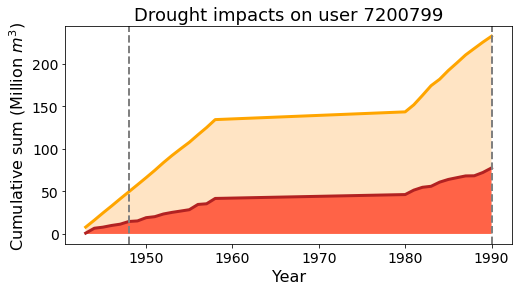

In [26]:
cum_sum_demands = np.cumsum(limited_df['annual_demand'].values)
cum_sum_shortages = np.cumsum(limited_df['annual_shortage'].values)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(allyears, cum_sum_demands, linewidth=3, color='orange', label='Cumulative demand')
ax.fill_between(allyears, 0, cum_sum_demands, 
                facecolor='bisque', interpolate=True)
ax.plot(allyears, cum_sum_shortages, linewidth=3, color='firebrick', label='Cumulative shortage')
ax.fill_between(allyears, 0, cum_sum_shortages, 
                facecolor='tomato', interpolate=True)

ax.axvline(x=np.min(years), linewidth=2, linestyle='--', color='grey')
ax.axvline(x=np.max(years), linewidth=2, linestyle='--', color='grey')


ax.tick_params(axis='both', labelsize=14)
ax.set_title("Drought impacts on user "+user_id, fontsize=18)
ax.set_ylabel("Cumulative sum (Million $m^3$)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
#ax.legend(fontsize=16, loc='upper left')
plt.show()